# Celeb Image Classification
This project uses OpenCV's Haar Cascade classifiers to detect faces and eyes in images. It also processes a dataset of celebrity images, crops the face if two eyes are detected, and saves the cropped images for further classification.

## Import Necessary Libraries
We begin by importing essential libraries for image processing, data handling, and visualization.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import shutil
import pywt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import joblib
import json
import pandas as pd

## Load and Display Test Image
We load a sample image (`test.webp`) from the test image folder to visualize and confirm the image's shape and content.

Image shape: (768, 1024, 3)


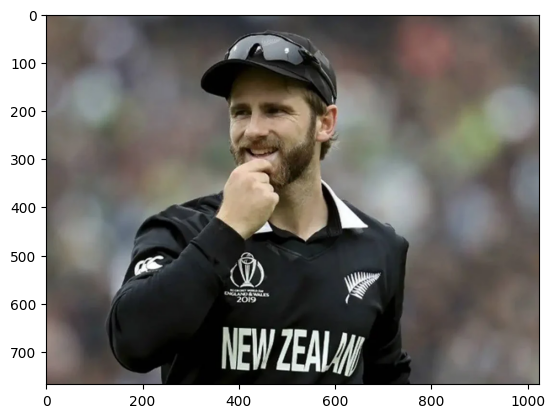

In [2]:
img = cv2.imread('test_images/kane1.webp')
print("Image shape:", img.shape)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert to RGB for correct display in matplotlib

## Convert Image to Grayscale
We convert the test image to grayscale, as face and eye detection using Haar Cascades works on single-channel grayscale images.

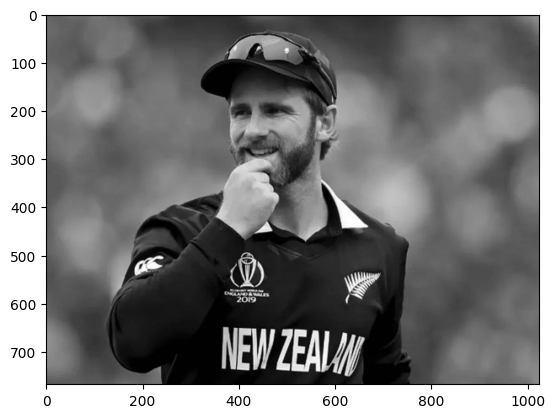

In [3]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

## Detect Faces in the Image
Using Haar Cascades for face detection, we detect the coordinates of any faces in the grayscale image. The function `detectMultiScale` returns a list of rectangles around detected faces.

In [4]:
face_cascade = cv2.CascadeClassifier("opencv/haarcascades/haarcascade_frontalface_default.xml")
eye_cascade = cv2.CascadeClassifier("opencv/haarcascades/haarcascade_eye.xml")

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
print(f"Faces: {faces}")

Faces: [[330 119 222 222]]


## Draw a Rectangle Around the Detected Face
We extract the coordinates of the first detected face and draw a rectangle around it on the original image.

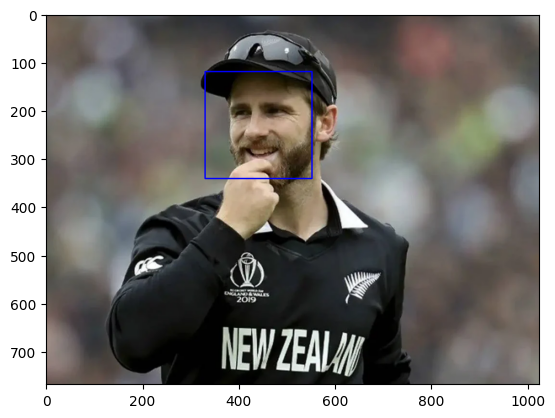

In [5]:
(x, y, w, h) = faces[0]  # Select the first detected face
face_img = cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)  # Blue rectangle
plt.imshow(cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB))

## Detect and Highlight Eyes Within the Detected Face
For each detected face, we use the eye Haar Cascade to detect eyes. We draw rectangles around both the face and eyes.

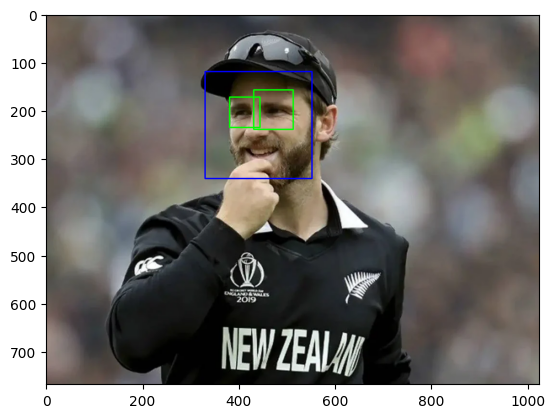

In [6]:
cv2.destroyAllWindows()

for (x, y, w, h) in faces:
    face_img = cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex, ey, ew, eh) in eyes:
        cv2.rectangle(roi_color, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 2)  # Green rectangle for eyes

plt.figure()
plt.imshow(cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB))
plt.show()

## Display Region of Interest (Face with Eyes)
Finally, we display the region of interest (cropped face area with eyes) to confirm successful detection and cropping.

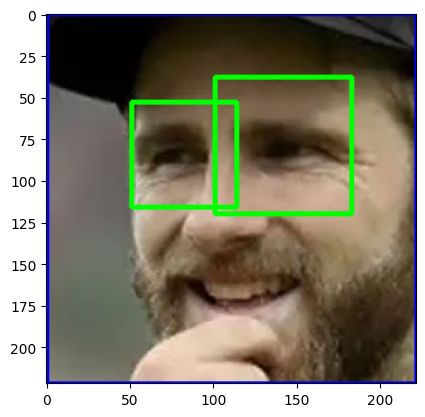

In [7]:
plt.imshow(cv2.cvtColor(roi_color, cv2.COLOR_BGR2RGB))

## Wavelet Transformation Function
A helper function to perform a Wavelet transformation on the image, which will be used for feature extraction.

In [8]:
def w2d(img, mode='haar', level=1):
    imArray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    imArray = np.float32(imArray)
    imArray /= 255
    coeffs = pywt.wavedec2(imArray, mode, level=level)
    coeffs_H = list(coeffs)
    coeffs_H[0] *= 0
    imArray_H = pywt.waverec2(coeffs_H, mode)
    imArray_H *= 255
    imArray_H = np.uint8(imArray_H)
    return imArray_H

## Function to Crop Image if 2 Eyes are Detected
This function detects faces and eyes in a given image. If two or more eyes are found, it crops and returns the face region.

In [9]:
import cv2

def get_cropped_image_if_2_eyes(image_path):
    # Read the image from the file
    img = cv2.imread(image_path)
    
    if img is None:
        print(f"Image not found at {image_path}")
        return None
    
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Detect faces in the image
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    
    # Loop through detected faces
    for (x, y, w, h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        
        # Detect eyes in the face region
        eyes = eye_cascade.detectMultiScale(roi_gray)
        
        # If two or more eyes are detected, return the cropped face
        if len(eyes) >= 2:
            return roi_color  # Return the cropped face image
    
    # If no face with two eyes is found, return None
    return None


## Define Dataset Paths
We define the paths for the original dataset (`images_dataset`) and the folder where the cropped images will be saved (`images_dataset/cropped`).

In [10]:
path_to_data = "./dataset/images"
path_to_cr_data = "./dataset/cropped_images/"

## Create List of Image Directories
We gather all the directories inside the dataset folder, which represent different celebrity folders.

In [11]:
img_dirs = [entry.path for entry in os.scandir(path_to_data) if entry.is_dir()]
print("Image directories:", img_dirs)

Image directories: ['./dataset/images\\Lionel Messi', './dataset/images\\Maria Sharapova', './dataset/images\\Roger Federer', './dataset/images\\Serena Williams', './dataset/images\\Virat Kohli']


## Clean and Recreate Cropped Image Directory
Before processing new images, we remove any old cropped data and recreate the cropped folder.

In [12]:
if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

## Process Each Celebrity Folder
Process the folders containing images of different celebrities, cropping and saving images.

In [13]:
def create_directory_if_not_exists(path):
    if not os.path.exists(path):
        os.makedirs(path)

def process_images_for_celebrity(img_dir, cropped_image_dirs, celebrity_file_names_dict):
    count = 1
    celebrity_name = os.path.basename(img_dir)
    print(f"Processing images for: {celebrity_name}")
    celebrity_file_names_dict[celebrity_name] = []

    for entry in os.scandir(img_dir):
        if entry.is_file():
            cropped_img = get_cropped_image_if_2_eyes(entry.path)
            if cropped_img is not None:
                cropped_folder = os.path.join(path_to_cr_data, celebrity_name)
                create_directory_if_not_exists(cropped_folder)
                
                cropped_file_name = f"{celebrity_name}_{count}.png"
                cropped_file_path = os.path.join(cropped_folder, cropped_file_name)
                cv2.imwrite(cropped_file_path, cropped_img)
                
                celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
                cropped_image_dirs.append(cropped_folder)
                count += 1

def process_all_celebrities(path_to_data, path_to_cr_data):
    img_dirs = [entry.path for entry in os.scandir(path_to_data) if entry.is_dir()]
    cropped_image_dirs = []
    celebrity_file_names_dict = {}
    for img_dir in img_dirs:
        process_images_for_celebrity(img_dir, cropped_image_dirs, celebrity_file_names_dict)
    return cropped_image_dirs, celebrity_file_names_dict

In [14]:
def clean_cropped_directory(path_to_cr_data):
    """
    Removes the cropped image directory if it exists and recreates it.
    
    Parameters:
    path_to_cr_data (str): Path to the directory where cropped images are stored.
    """
    if os.path.exists(path_to_cr_data):
        shutil.rmtree(path_to_cr_data)  # Remove the existing directory
    os.mkdir(path_to_cr_data)  # Recreate an empty directory


## Execute the Cropping Process
We now call the functions to process all celebrity images and save the cropped faces.

In [15]:
clean_cropped_directory(path_to_cr_data)
cropped_image_dirs, celebrity_file_names_dict = process_all_celebrities(path_to_data, path_to_cr_data)

Processing images for: Lionel Messi
Processing images for: Maria Sharapova
Processing images for: Roger Federer
Processing images for: Serena Williams
Processing images for: Virat Kohli


## Create a Class Dictionary
Create a dictionary mapping each celebrity's name to a unique numerical label.

In [16]:
class_dict = {}
count = 1
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count += 1

In [17]:
class_dict

{'Lionel Messi': 1,
 'Maria Sharapova': 2,
 'Roger Federer': 3,
 'Serena Williams': 4,
 'Virat Kohli': 5}

## Prepare Training Data
For each celebrity, read the cropped images, resize them, and perform a wavelet transformation for feature extraction.

In [18]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img, 'db1', 5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((
            scalled_raw_img.reshape(32*32*3, 1),
            scalled_img_har.reshape(32*32, 1)
        ))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])

X = np.array(X).reshape(len(X), 4096).astype(float)
y = np.array(y)

## Train-Test Split
We split the dataset into training and testing sets (80/20 split).

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Training with Grid Search
We train multiple models using `GridSearchCV` to tune hyperparameters. We include SVM, RandomForest, and Logistic Regression as candidate classifiers.

In [20]:
pipe = make_pipeline(StandardScaler(), SVC(probability=True))
param_grid = {'svc__C': [1, 10, 100, 1000], 'svc__kernel': ['rbf', 'linear']}
model = GridSearchCV(pipe, param_grid, cv=5, return_train_score=False)

model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('svc', SVC(probability=True))]),
             param_grid={'svc__C': [1, 10, 100, 1000],
                         'svc__kernel': ['rbf', 'linear']})

## Model Evaluation
We evaluate the model on the test set and display the classification report.

In [21]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.78      0.78      0.78         9
           2       0.71      1.00      0.83         5
           3       0.67      0.80      0.73         5
           4       1.00      1.00      1.00         6
           5       0.90      0.69      0.78        13

    accuracy                           0.82        38
   macro avg       0.81      0.85      0.82        38
weighted avg       0.83      0.82      0.82        38



## Save Model and Class Dictionary
We save the trained model and the class dictionary to disk for later use in predictions.

In [22]:
joblib.dump(model, 'saved_model.pkl')
with open('class_dictionary.json', 'w') as f:
    json.dump(class_dict, f)

## Test Image Prediction
This section demonstrates how to load the model and use it to predict the celebrity class of a new test image.

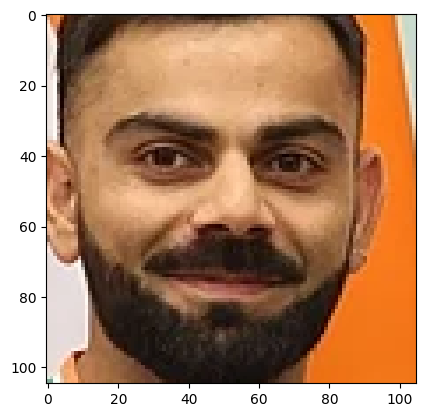

{'Lionel Messi': 10.54,
 'Maria Sharapova': 0.78,
 'Roger Federer': 0.43,
 'Serena Williams': 3.92,
 'Virat Kohli': 84.33}

In [41]:
import joblib
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the pre-trained model
model = joblib.load('saved_model.pkl')

def predict_celebrity(test_image_path, model):
    # Get cropped image
    img = get_cropped_image_if_2_eyes(test_image_path)
    
    if img is None:
        print("No face with 2 eyes detected.")
        return {"Prediction failed": "No face detected."}
    
    # Resize the cropped image to (32, 32)
    scalled_raw_img = cv2.resize(img, (32, 32))
    
    # Display the scaled image
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Converting BGR to RGB for display
    plt.show()

    # Apply wavelet transform
    img_har = w2d(img, 'db1', 5)  # Ensure the w2d function is defined

    # Resize the wavelet-transformed image to (32, 32)
    scalled_img_har = cv2.resize(img_har, (32, 32))

    # Combine raw and wavelet-transformed image
    combined_img = np.vstack((
        scalled_raw_img.reshape(32*32*3, 1),
        scalled_img_har.reshape(32*32, 1)
    ))

    # Prepare the image for prediction
    X = combined_img.reshape(1, -1).astype(float)
    
    # Predict the class probabilities
    predicted_probabilities = model.predict_proba(X)[0]  # Get probabilities for all classes
    names = list(class_dict.keys())
    response = {}
    for i in range(len(names)):
        response[names[i]] = round(float(predicted_probabilities[i] * 100),2)
        # print(f"{names[i]}:{predicted_probabilities[i]}")
    return response

# Test the prediction
test_image_path = 'test_images/virat1.webp'
prediction_percentages = predict_celebrity(test_image_path, model)
prediction_percentages